In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

np.random.seed(13)

In [2]:
x = np.arange(-100, 101, 0.01)
y = np.zeros(x.shape)

In [3]:
lr = joblib.load('lr_wp_model.joblib')

In [4]:
y_lr = lr.predict_proba(x.reshape(-1, 1)) @ np.array([0, 0.5, 1])

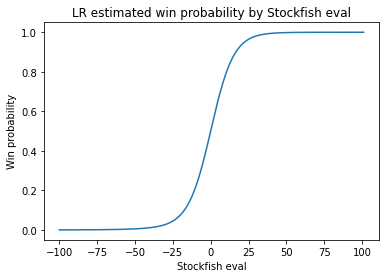

In [5]:
plt.plot(x, y_lr)
plt.title('LR estimated win probability by Stockfish eval')
plt.xlabel('Stockfish eval')
plt.ylabel('Win probability');

In [6]:
df = pd.DataFrame([x, y_lr]).T
df.columns = ['x', 'y_lr']
df = df.append([{'x': 9999, 'y_lr': 1}, {'x': -9999, 'y_lr': 0}], ignore_index=True)
df['x'] = df['x'].round(2)
df['y_lr'] = df['y_lr'].round(6)
df.sort_values(by='x', ascending=True, inplace=True)
df

,x,y_lr
20101,-9999.00,0.000000
0,-100.00,0.000362
1,-99.99,0.000362
2,-99.98,0.000363
3,-99.97,0.000363
...,...,...
20096,100.96,0.999990
20097,100.97,0.999990
20098,100.98,0.999990
20099,100.99,0.999990


In [7]:
df.to_csv('../content/win_probabilities.csv', index=None, header=None)